In [1]:

import numpy as np
import matplotlib.pyplot as plt

TIME_ZOOM = 0.06    # 60 ms
FMAX_PLOT = 8000    # 0–8 kHz

def ema_filter(x, alpha: float):
    """y[n] = α x[n] + (1-α) y[n-1]"""
    y = np.empty_like(x)
    y[0] = alpha * x[0]
    a1 = 1.0 - alpha
    for n in range(1, len(x)):
        y[n] = alpha * x[n] + a1 * y[n-1]
    return y

def espectro_db(sig, fs):
    """FFT en dB con ventana de Hann (magnitud)"""
    N = len(sig)
    w = np.hanning(N)
    # normalización suave usando suma de la ventana
    X = np.fft.rfft(sig * w) / (np.sum(w)/2)
    f = np.fft.rfftfreq(N, d=1/fs)
    mag = 20*np.log10(np.abs(X) + 1e-12)
    return f, mag

def find_loudest_window(x, fs, win_s=0.06):
    """Índices [i0,i1) de la ventana de 'win_s' con mayor energía."""
    N = len(x)
    W = max(8, int(win_s * fs))
    if W >= N:
        return 0, N
    p = np.convolve(x.astype(np.float32)**2, np.ones(W, dtype=np.float32), mode='valid')
    i0 = int(np.argmax(p))
    return i0, i0 + W

def plot_tiempo_zoom(x, y, fs, alpha, win_s=TIME_ZOOM):
    """Tiempo (zoom) usando la ventana más enérgica para que no quede “plano”."""
    i0, i1 = find_loudest_window(x, fs, win_s=win_s)
    xw = x[i0:i1]; yw = y[i0:i1]
    t  = np.arange(len(xw))/fs
    s = max(np.max(np.abs(xw)), 1e-12)  # norma local para visualizar
    plt.figure(figsize=(8,5))
    plt.plot(t, xw/s, '--', lw=1.1, label='Original (norm. local)')
    plt.plot(t, yw/s,  '-',  lw=1.3, label=f'Filtrada (α={alpha})')
    plt.xlabel("Tiempo [s]"); plt.ylabel("Amplitud (norm)")
    plt.title(f"Señal original vs. filtrada — EMA (α={alpha})\n"
              f"(ventana más enérgica: {win_s*1e3:.0f} ms)")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.show()

def plot_espectro(x, y, fs, alpha, fmax=FMAX_PLOT):
    f1, M1 = espectro_db(x, fs)
    f2, M2 = espectro_db(y, fs)
    plt.figure(figsize=(8,5))
    plt.plot(f1, M1, '--', lw=1.0, label='Original')
    plt.plot(f2, M2,  '-', lw=1.2, label=f'Filtrada (α={alpha})')
    plt.xlim(0, fmax)
    plt.xlabel("Frecuencia [Hz]"); plt.ylabel("Magnitud [dB]")
    plt.title(f"Espectro de frecuencias (0–{fmax//1000} kHz) — EMA (α={alpha})")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.show()


In [4]:
# @title Grabar 5 s con el mic del navegador y convertir a WAV
from IPython.display import Javascript, display
from google.colab import output
import base64, io, os, subprocess

DURACION_SEG = 5  # @param {type:"number"}

RECORD_JS = f"""
async function recordAudio() {{
  const stream = await navigator.mediaDevices.getUserMedia({{ audio: true }});
  const mediaRecorder = new MediaRecorder(stream);
  let audioChunks = [];

  mediaRecorder.ondataavailable = e => audioChunks.push(e.data);
  mediaRecorder.start();

  // grabar DURACION_SEG
  await new Promise(r => setTimeout(r, {int(DURACION_SEG*1000)}));
  mediaRecorder.stop();

  await new Promise(resolve => {{
    mediaRecorder.onstop = () => {{
      const blob = new Blob(audioChunks, {{ type: 'audio/webm' }});
      const reader = new FileReader();
      reader.readAsDataURL(blob);
      reader.onloadend = () => {{
        const b64 = reader.result.split(',')[1];
        google.colab.kernel.invokeFunction('notebook.saveAudio', [b64], {{}});
        resolve();
      }};
    }};
  }});
}}
recordAudio();
"""

def save_audio(b64_audio):
    """guarda WebM y convierte a WAV mono 44.1 kHz con ffmpeg (binario de Colab)"""
    webm = base64.b64decode(b64_audio)
    with open("grabacion.webm", "wb") as f:
        f.write(webm)
    print("🎤 Audio guardado: grabacion.webm")

    # convertir con ffmpeg (colab tiene /usr/bin/ffmpeg)
    cmd = ["ffmpeg", "-y", "-i", "grabacion.webm",
           "-ac", "1", "-ar", "44100", "grabacion.wav"]
    subprocess.run(cmd, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    print("✅ Conversión lista: grabacion.wav (mono, 44.1 kHz)")

output.register_callback('notebook.saveAudio', save_audio)
display(Javascript(RECORD_JS))


<IPython.core.display.Javascript object>

🎤 Audio guardado: grabacion.webm
✅ Conversión lista: grabacion.wav (mono, 44.1 kHz)


fs = 44100 Hz | duración = 4.98 s | RMS = 4.098e-02


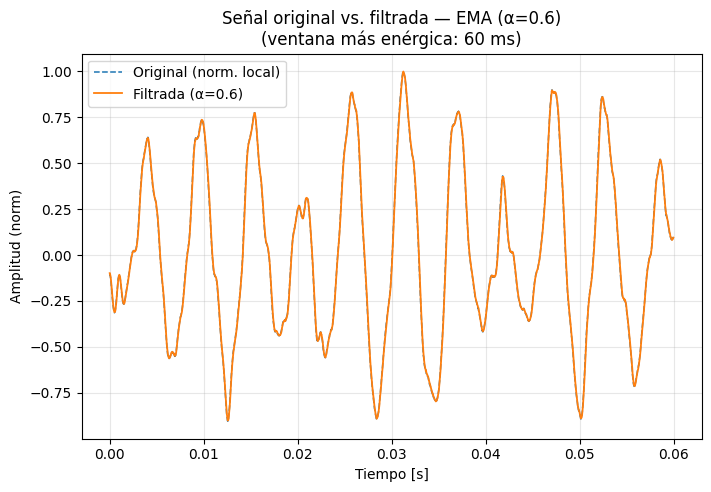

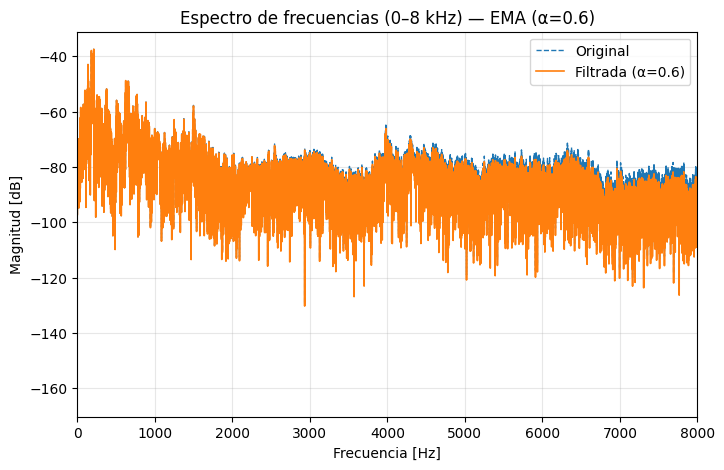

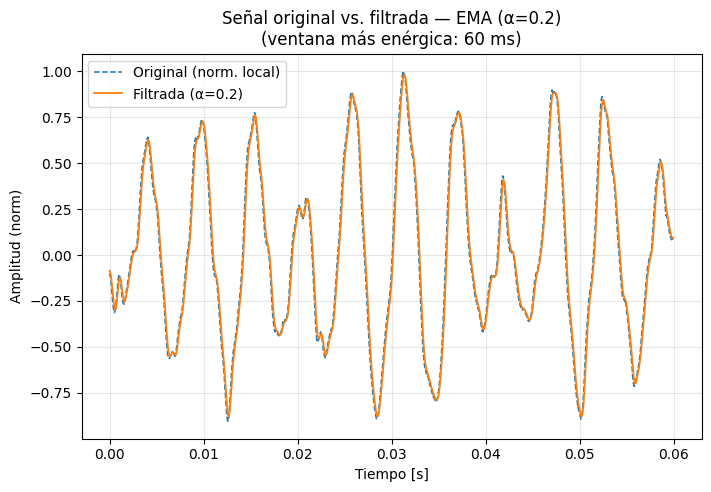

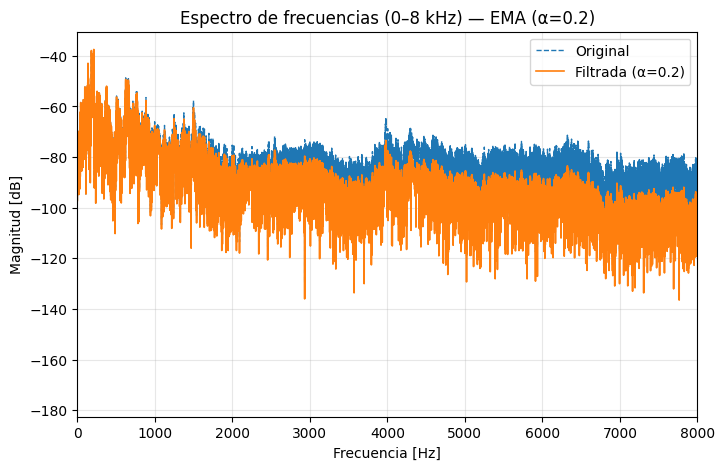

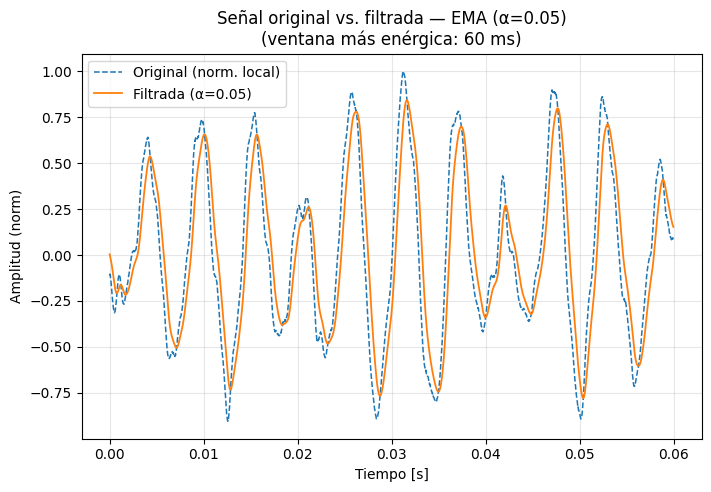

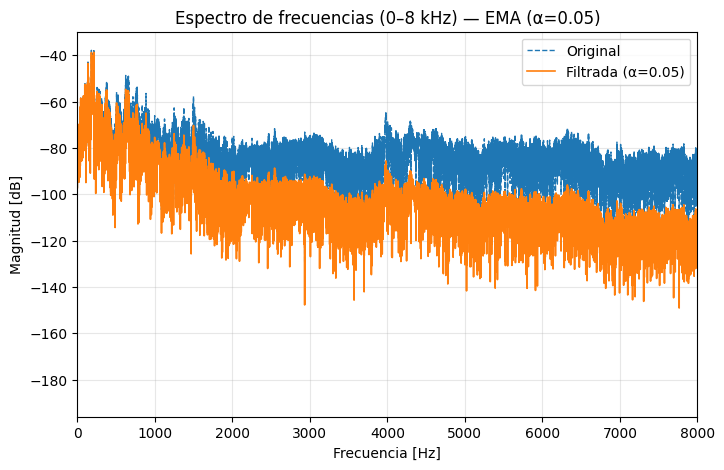

In [5]:
# @title Procesar y graficar (EMA con α = 0.6, 0.2, 0.05)
import soundfile as sf
import numpy as np

WAV_PATH = "grabacion.wav"  # si subiste archivo, poné su nombre aquí
ALPHAS   = [0.6, 0.2, 0.05]

# cargar
x, fs = sf.read(WAV_PATH)    # x: (N,) o (N, C)
if x.ndim == 2:
    x = x[:,0]               # primer canal
x = x.astype(np.float32)
x = x - np.mean(x)

dur = len(x)/fs
rms = float(np.sqrt(np.mean(x**2)))
print(f"fs = {fs} Hz | duración = {dur:.2f} s | RMS = {rms:.3e}")

# filtrar y graficar
for a in ALPHAS:
    y = ema_filter(x, a)
    plot_tiempo_zoom(x, y, fs, a)     # tiempo (ventana más enérgica)
    plot_espectro(x, y, fs, a)        # espectro 0–8 kHz
